# Projet : Morphotypes du corps humain
#### Objectif
- classifier les types de morphologies du corps humain

#### Modèle
- clustering non supervisé

#### Importation des packages nécessaires

In [1]:
try:
    import pandas as pd
except:
    %pip install pandas
    import pandas as pd
try:
    import seaborn as sns
except:
    %pip install seaborn
    import seaborn as sns
try:
    from sklearn.cluster import KMeans, AgglomerativeClustering
except:
    %pip install scikit-learn
    from sklearn.cluster import KMeans, AgglomerativeClustering
try:
    from sklearn_extra.cluster import KMedoids
except:
    %pip install scikit-learn-extra
    from sklearn_extra.cluster import KMedoids
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    %pip install yellowbrick
    from yellowbrick.cluster import KElbowVisualizer

import numpy as np
import scipy.cluster.hierarchy as shc
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# 1. Exploration du jeu de données

- On importe la base de données ANSUR II concernant des mensurations de femmes

Pour plus d'informations concernant cette base, voir : https://www.openlab.psu.edu/ansur2/

In [2]:
# chemin vers le jeu de données (A CHANGER SI NECESSAIRE)
df = pd.read_csv(r'http://tools.openlab.psu.edu/publicData/ANSUR_II_FEMALE_Public.csv')

- Taille du jeu de données

In [3]:
df.shape

(1986, 108)

- Premières lignes du jeu de données

In [4]:
df.head(10)

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,...,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,...,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,...,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,...,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,...,Combat Arms,42A,Texas,1,NaN,1,45,63,195,Right hand
5,10053,272,1428,326,228,1326,229,201,356,342,...,Combat Service Support,88M,Germany,2,NaN,2,44,67,180,Left hand
6,10061,261,1352,306,223,1246,232,172,358,320,...,Combat Service Support,35F,New Mexico,1,NaN,1,21,65,165,Right hand
7,10070,229,1383,327,205,1281,234,194,365,337,...,Combat Service Support,92Y,American Samoa,6,Polynesian Samoan,6,23,66,168,Right hand
8,10077,213,1237,308,193,1135,208,175,355,283,...,Combat Service Support,92F,Virginia,2,NaN,2,24,59,118,Left hand
9,10080,281,1301,278,208,1194,221,178,323,290,...,Combat Service Support,31B,South Korea,1,NaN,1,37,63,150,Right hand


- On regarde le type des colonnes

In [5]:
df.dtypes

SubjectId                          int64
abdominalextensiondepthsitting     int64
acromialheight                     int64
acromionradialelength              int64
anklecircumference                 int64
                                   ...  
DODRace                            int64
Age                                int64
Heightin                           int64
Weightlbs                          int64
WritingPreference                 object
Length: 108, dtype: object

- Répartition des valeurs manquantes

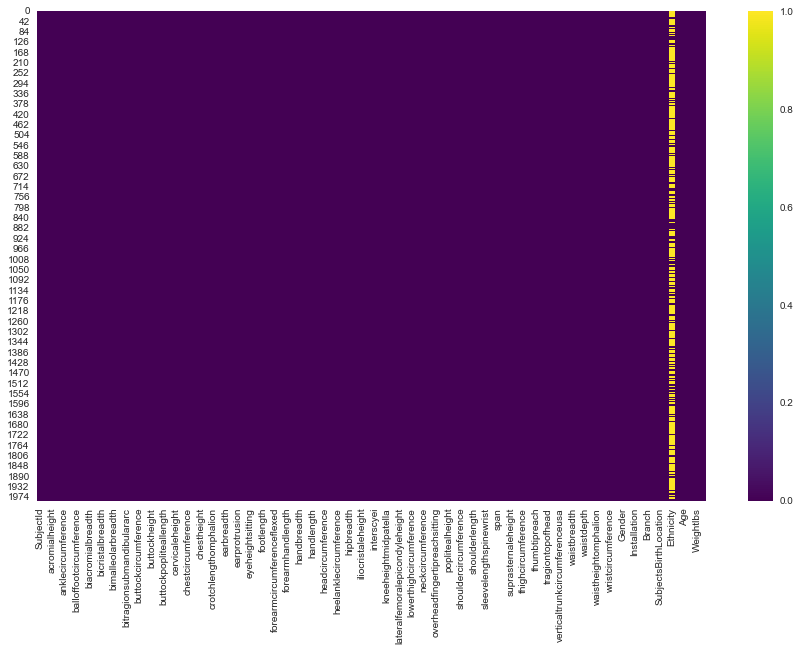

In [6]:
plt.figure(figsize=(15, 9))
sns.heatmap(df.isnull(), cmap='viridis')
plt.show()

- Tableau de corrélation des caractéristiques

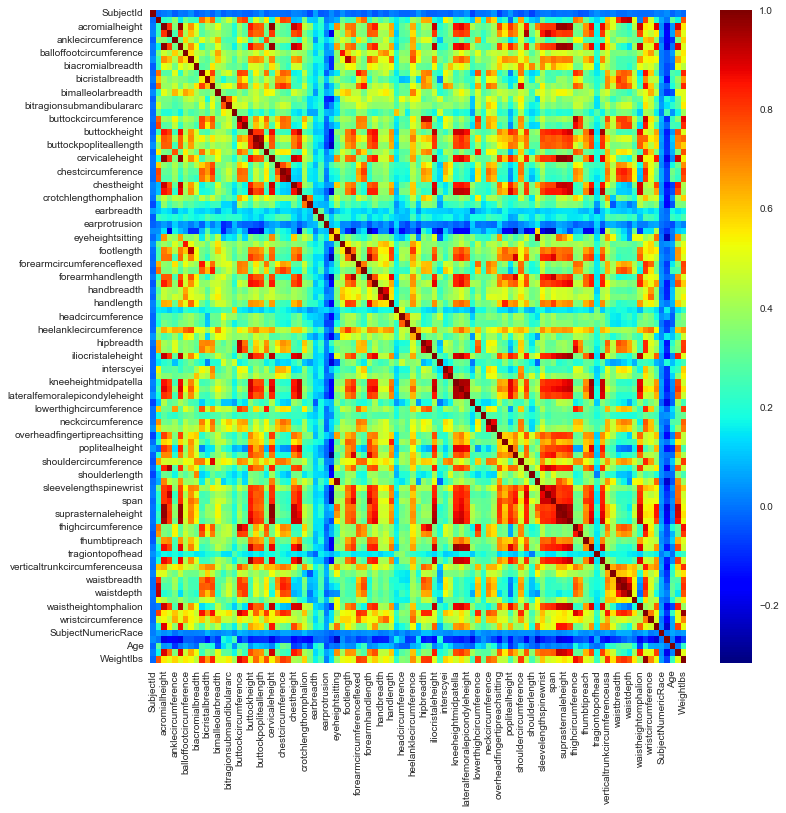

In [7]:
fig, ax = plt.subplots(figsize=(12, 12)) # Pour augmenter la taille de la figure
sns.heatmap(df.corr(), cmap="jet")
plt.show()

# 2. Préparation du jeu de données

- On supprime les données non pertinentes (âge, taille, poids, numéro d'identification, arme, ...).

In [8]:
df_fit_ = df.copy().select_dtypes(include='number')

In [9]:
todrop = ['SubjectId',
          'weightkg',
          'Weightlbs',
          'Heightin',
          'SubjectNumericRace',
          'DODRace',
          'Age']

for col in todrop:
    df_fit_.pop(col)

### Tête, mains et pieds

In [10]:
todrop = ['handbreadth',
          'handcircumference',
          'handlength',
          'palmlength',
          'interpupillarybreadth',
          'tragiontopofhead',
          'mentonsellionlength',
          'earbreadth',
          'earlength',
          'earprotrusion',
          'headbreadth',
          'headcircumference',
          'headlength',
          'heelanklecircumference',
          'balloffootcircumference',
          'balloffootlength',
          'bimalleolarbreadth',
          'bitragionchinarc',
          'bitragionsubmandibulararc',
          'bizygomaticbreadth',
          'calfcircumference',
          'lateralmalleolusheight',
          'forearmcircumferenceflexed',
          'bicepscircumferenceflexed',
          'footbreadthhorizontal',
          'footlength']

for col in todrop:
    df_fit_.pop(col)

### Extensions

In [11]:
todrop = ['sittingheight',
          'eyeheightsitting',
          'elbowrestheight',
          'thighclearance',
          'kneeheightsitting',
          'poplitealheight',
          'heelbreadth',
          'buttockkneelength',
          'buttockpopliteallength',
          'waistfrontlengthsitting',
          'biacromialbreadth',
          'bideltoidbreadth',
          'forearmforearmbreadth',
          'abdominalextensiondepthsitting',
          'hipbreadthsitting',
          'functionalleglength',
          'overheadfingertipreachsitting',
          'anklecircumference',
          'wristcircumference',
          'span',
          'thumbtipreach']

for col in todrop:
    df_fit_.pop(col)

In [12]:
for col in df_fit_.columns:
    if 'height' in col or 'stature' in col or 'scye' in col or 'neck' in col or 'length' in col or 'sleev' in col:
        df_fit_.pop(col)

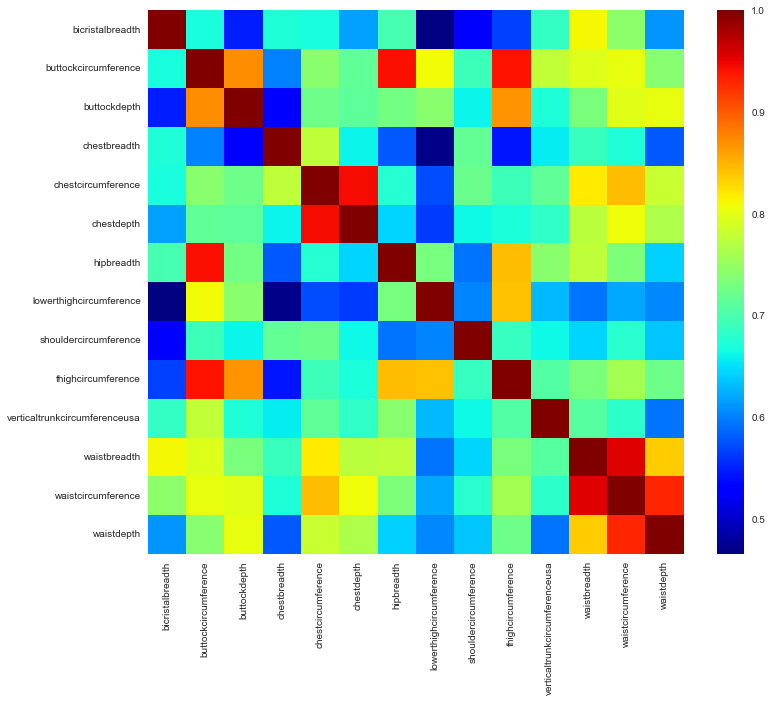

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_fit_.corr(), cmap="jet")
plt.show()

#### Normalisation des données

In [14]:
df_fit = (df_fit_.copy() - df_fit_.mean()) / df_fit_.std()

### Méthode elbow

#### K-Medoids

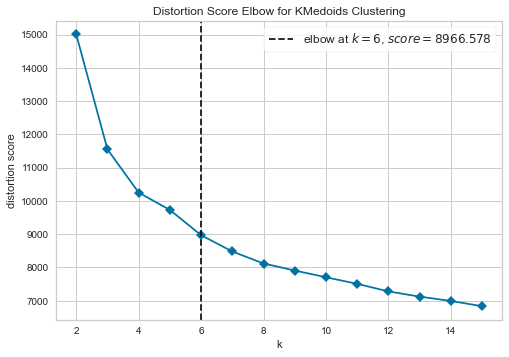

<AxesSubplot:title={'center':'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
model = KMedoids(method='pam')
visualizer = KElbowVisualizer(model, k=(2, 16), timings=False)

visualizer.fit(df_fit)
visualizer.show()

#### K-Means

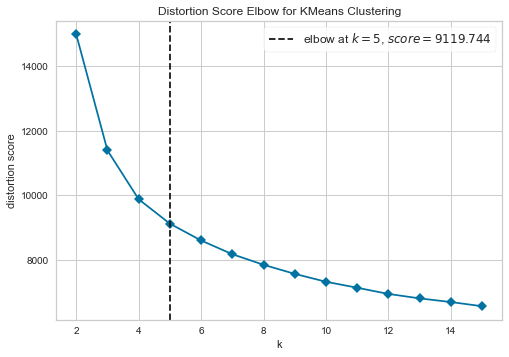

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 16), timings=False)

visualizer.fit(df_fit)
visualizer.show()

#### Hierarchical

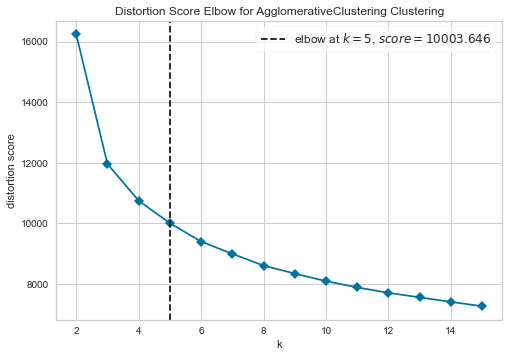

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model = AgglomerativeClustering(linkage='ward')
visualizer = KElbowVisualizer(model, k=(2, 16), timings=False)

visualizer.fit(df_fit)
visualizer.show()

- Voici deux autres méthodes utilisables pour déterminer un nombre de clusters optimal.

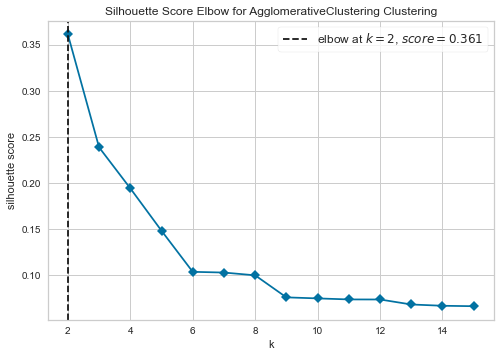

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [18]:
visualizer = KElbowVisualizer(
    model, k=(2, 16), metric='silhouette', timings=False)
visualizer.fit(df_fit)        # Fit the data to the visualizer
visualizer.show()

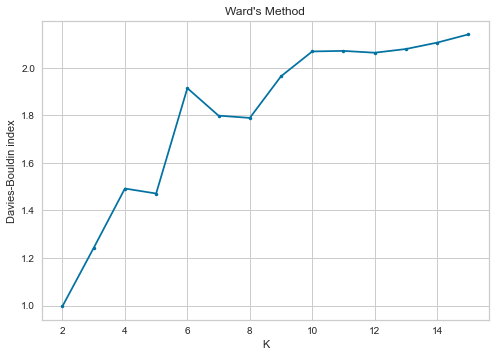

In [19]:
db_index = []
ks = range(2, 16)
for k in ks:
    khier = AgglomerativeClustering(k, linkage='ward')
    labels = khier.fit_predict(df_fit)
    db_index.append(davies_bouldin_score(df_fit, labels))

plt.title('Ward\'s Method')
plt.xlabel('K')
plt.ylabel('Davies-Bouldin index')
plt.plot(ks, db_index, '.-')
plt.show()

On voit qu'elles sont inadaptées à notre base de données.

### Visualisation

In [20]:
colors = ['ro', 'g^', 'bs', 'cX', 'yP', 'm*', 'kH']

def clustering(data, method, plot=True):
    method.fit(data)
    identified_clusters = method.fit_predict(data)

    acp = PCA(n_components=2, svd_solver='full')
    coord = acp.fit_transform(data)

    if not plot:
        print(100*sum(acp.explained_variance_ratio_),
              '% ot the variance retained')
    else:
        x_proj = acp.transform(data)
        x_proj = pd.DataFrame(data=x_proj, columns=[
            'Composante principale 1', 'Composante principale 2'])
        x_proj['Clusters'] = identified_clusters

        fig, ax = plt.subplots(figsize=(25, 25))
        plt.xlabel('First component: {:.2f}%'.format(100*acp.explained_variance_ratio_[0]), fontsize=20)
        plt.ylabel('Second component: {:.2f}%'.format(100*acp.explained_variance_ratio_[1]), fontsize=20)
        for i in range(x_proj['Clusters'].max()+1):
            plt.plot(x_proj[x_proj['Clusters']==i]['Composante principale 1'],
                        x_proj[x_proj['Clusters']==i]['Composante principale 2'], colors[i], label='Cluster {}'.format(i+1), alpha=0.7)
        plt.legend(loc='best', fontsize=20)
        plt.show()

#### Hierarchical

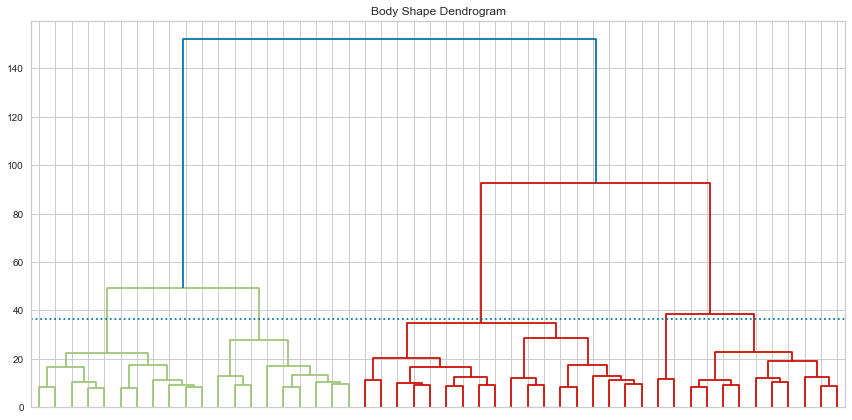

In [21]:
plt.figure(figsize=(12, 6))
plt.title("Body Shape Dendrogram")
dend = shc.dendrogram(shc.linkage(df_fit, method='ward'), p=50, truncate_mode='lastp', show_leaf_counts=False)
plt.plot([0, 500], [36.5, 36.5], ':')
plt.tight_layout()

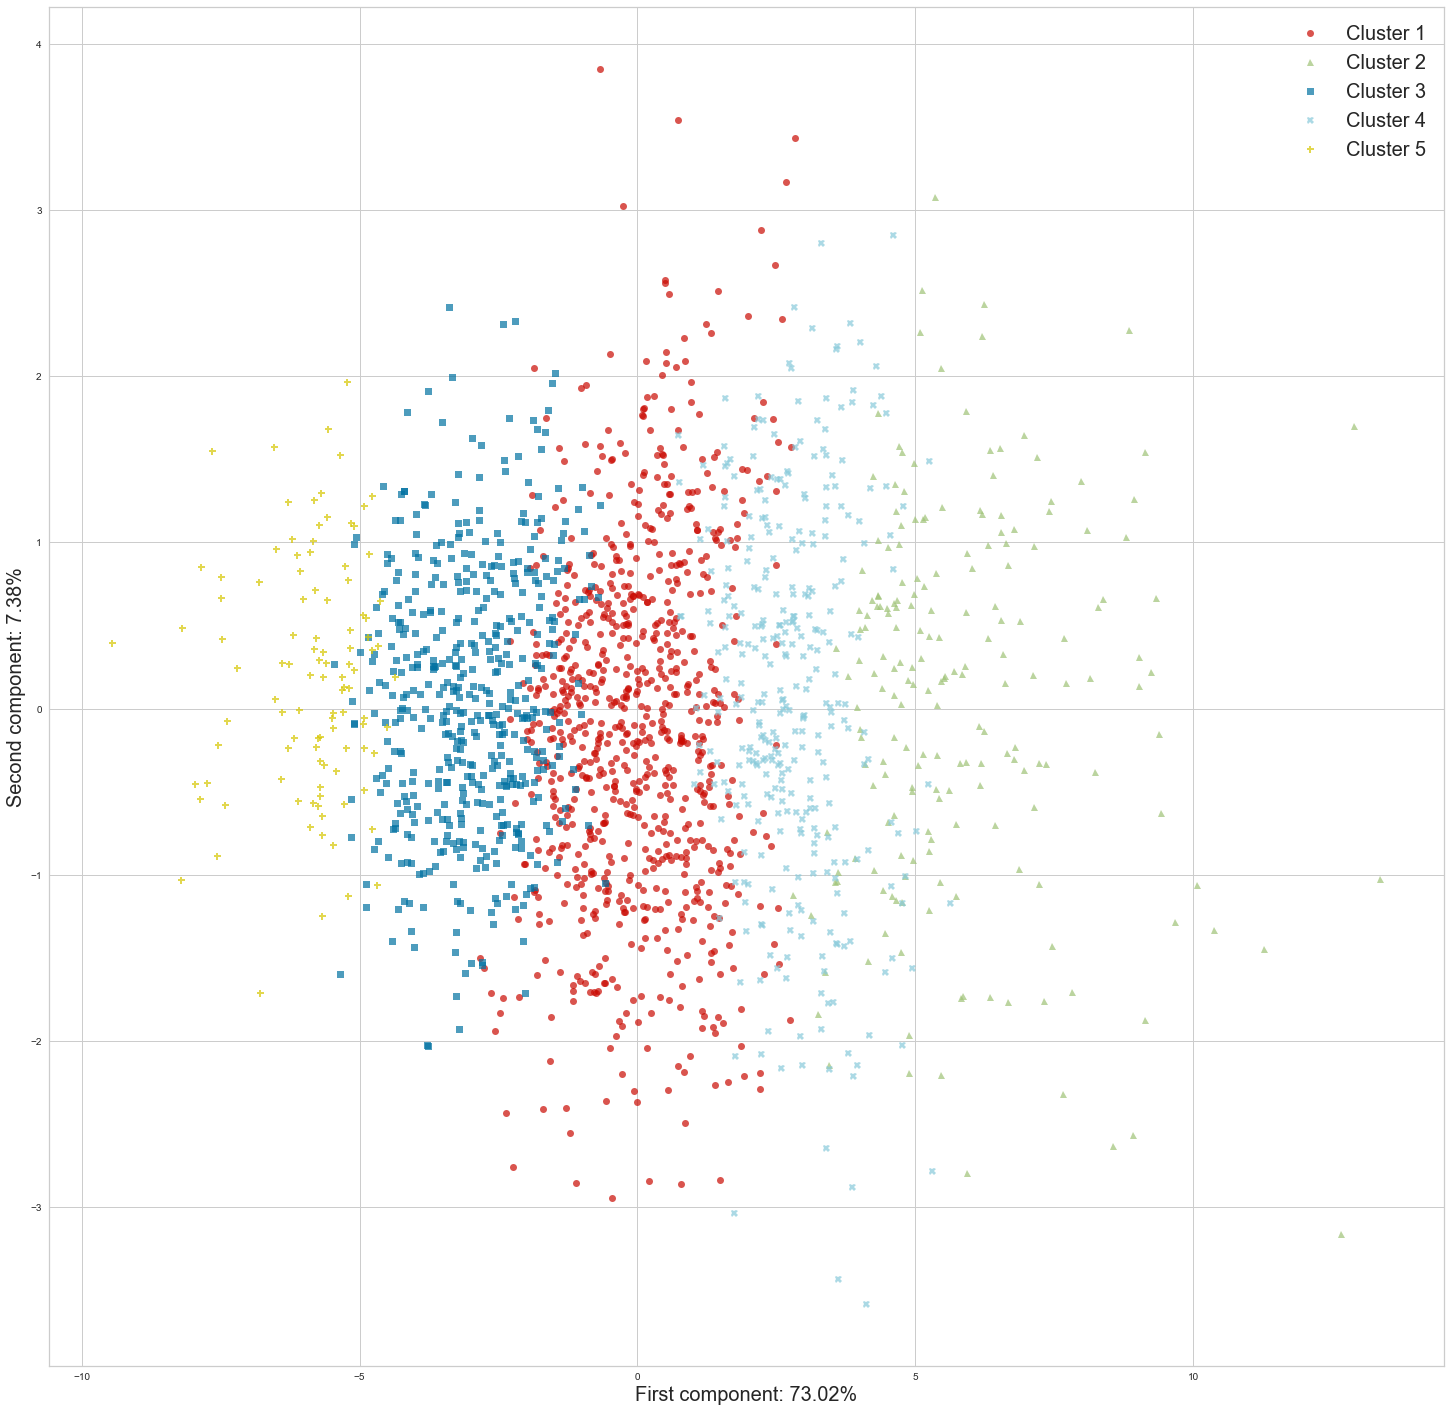

In [22]:
clustering(df_fit, AgglomerativeClustering(5, linkage='ward'))

#### K-Means

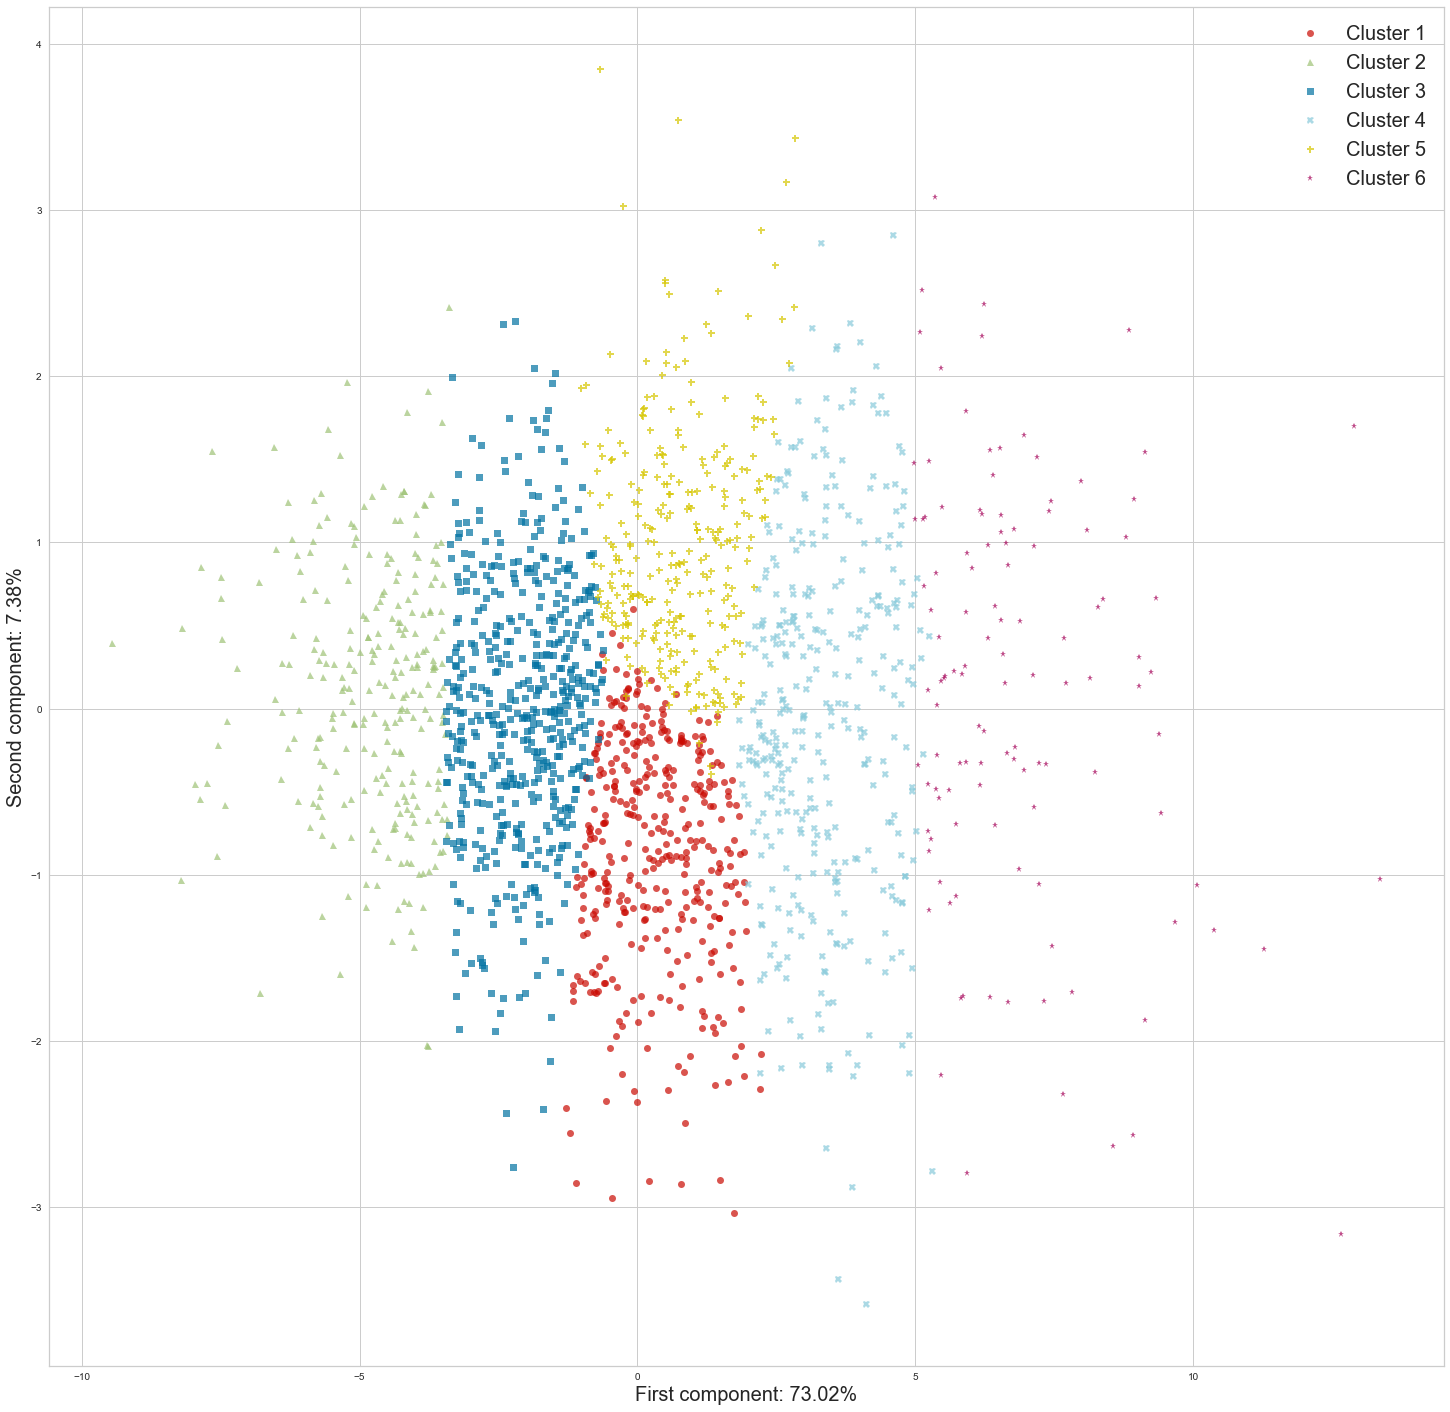

In [23]:
clustering(df_fit, KMeans(6))

#### K-Medoids

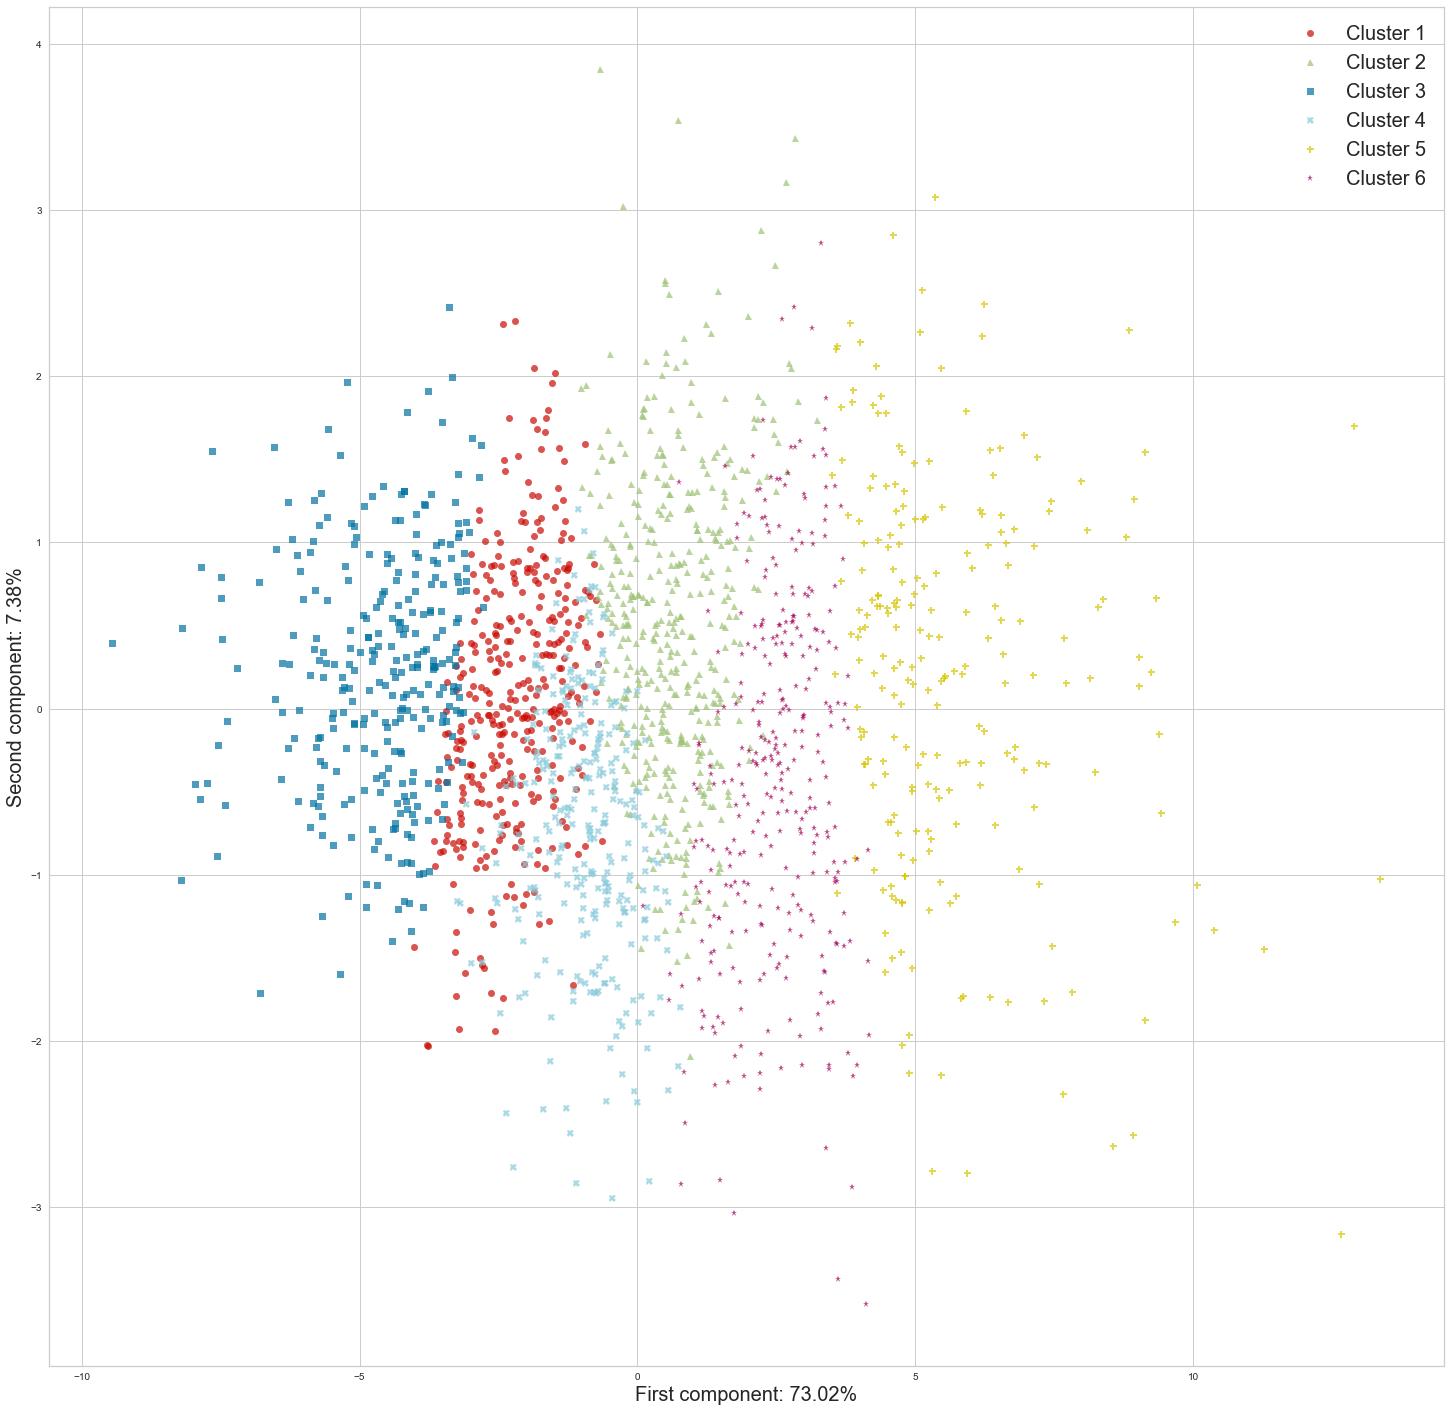

In [24]:
clustering(df_fit, KMedoids(6, method='pam'))

## Clusters Descriptions

### *Hierarchical*

In [25]:
method = AgglomerativeClustering(5, linkage='ward')
method.fit(df_fit)
identified_clusters = method.fit_predict(df_fit)

df_means = df.select_dtypes(include='number').copy()

df_means["Cluster"] = identified_clusters.copy()
df_means["Weight"] = df_means["Weightlbs"].copy() * 0.453592
df_means["Height"] = df_means["Heightin"].copy() * 2.54
df_means["BMI"] = 10000 * df_means['Weight'] / df_means['Height']**2
df_fit_["Cluster"] = identified_clusters.copy()

In [26]:
todrop = ['SubjectId',
          'SubjectNumericRace',
          'DODRace',
          'Weightlbs',
          'weightkg',
          'Heightin']

for col in todrop:
    df_means.pop(col)

In [27]:
df_medoids = df_fit.copy()
df_medoids["Cluster"] = identified_clusters.copy()

#### Cluster 1

In [28]:
df_medoid1 = df_medoids[df_medoids["Cluster"] == 0]
medoid1 = np.argmin(((df_medoid1 - df_medoid1.mean())**2).sum(axis=1))
print(medoid1)

453


**Description**

In [29]:
cluster1 = df_means[df_means["Cluster"]==0]
cluster1.pop('Cluster')
cluster1.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,...,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000
mean,227.936221,1335.996390,311.310469,216.913357,1239.660650,229.107100,182.459687,366.137184,305.954272,272.003610,...,856.814681,210.788207,354.955475,982.006017,154.884477,794.936221,28.709988,66.659465,164.198315,24.777682
std,18.207758,54.824946,15.743344,13.087829,54.353133,10.733545,9.225580,16.952178,18.627168,15.094441,...,48.722072,17.955860,20.397536,49.585401,6.427249,37.314644,8.151806,4.973404,6.738849,2.000494
min,174.000000,1188.000000,265.000000,185.000000,1082.000000,199.000000,156.000000,316.000000,254.000000,227.000000,...,727.000000,159.000000,295.000000,840.000000,137.000000,690.000000,17.000000,52.616672,144.780000,16.998646
25%,215.000000,1298.500000,300.500000,208.000000,1200.000000,222.000000,176.000000,355.000000,293.000000,262.000000,...,822.000000,199.000000,341.500000,947.000000,150.000000,770.000000,22.000000,63.502880,160.020000,23.403353
50%,227.000000,1334.000000,311.000000,216.000000,1237.000000,228.000000,182.000000,366.000000,305.000000,272.000000,...,855.000000,209.000000,355.000000,979.000000,155.000000,793.000000,27.000000,65.770840,162.560000,24.746024
75%,240.000000,1374.000000,323.000000,225.000000,1278.000000,237.000000,188.000000,378.000000,318.000000,283.000000,...,888.000000,222.000000,368.000000,1015.000000,159.500000,819.000000,33.000000,70.306760,167.640000,26.007043
max,288.000000,1516.000000,361.000000,275.000000,1419.000000,263.000000,216.000000,422.000000,369.000000,313.000000,...,1021.000000,284.000000,411.000000,1142.000000,180.000000,918.000000,58.000000,90.718400,203.200000,34.329541


**Medoid**

In [30]:
df_fit_[df_fit_["Cluster"] == 0].iloc[medoid1]

bicristalbreadth                  271
buttockcircumference             1011
buttockdepth                      236
chestbreadth                      274
chestcircumference                926
chestdepth                        245
hipbreadth                        346
lowerthighcircumference           408
shouldercircumference            1013
thighcircumference                635
verticaltrunkcircumferenceusa    1604
waistbreadth                      288
waistcircumference                847
waistdepth                        213
Cluster                             0
Name: 1112, dtype: int64

In [31]:
cluster1.iloc[medoid1]

abdominalextensiondepthsitting     227.00000
acromialheight                    1333.00000
acromionradialelength              300.00000
anklecircumference                 235.00000
axillaheight                      1237.00000
                                     ...    
wristheight                        820.00000
Age                                 18.00000
Weight                              68.03880
Height                             165.10000
BMI                                 24.96103
Name: 1112, Length: 96, dtype: float64

#### Cluster 2

In [32]:
df_medoid2 = df_medoids[df_medoids["Cluster"] == 1]
medoid2 = np.argmin(((df_medoid2 - df_medoid2.mean())**2).sum(axis=1))
print(medoid2)

19


**Description**

In [33]:
cluster2 = df_means[df_means["Cluster"]==1]
cluster2.pop('Cluster')
cluster2.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,283.425000,1375.040000,322.315000,229.455000,1271.295000,236.965000,188.975000,377.020000,355.810000,304.44000,...,1036.325000,268.050000,379.845000,994.240000,163.855000,820.410000,32.900000,85.161898,168.668700,30.003625
std,22.657919,59.394418,18.420433,14.116101,58.274847,11.435367,9.412617,17.498589,24.844115,18.45234,...,67.013232,25.230147,21.260551,55.949927,7.793437,36.721715,8.949327,8.185744,7.601246,2.916290
min,231.000000,1191.000000,266.000000,193.000000,1082.000000,201.000000,151.000000,335.000000,294.000000,264.00000,...,895.000000,215.000000,326.000000,828.000000,145.000000,734.000000,18.000000,63.502880,149.860000,20.087686
25%,270.000000,1332.750000,309.000000,220.000000,1229.750000,229.000000,184.000000,365.000000,337.750000,292.00000,...,980.750000,251.000000,364.000000,952.000000,157.750000,797.750000,26.000000,80.172386,162.560000,27.890130
50%,282.000000,1374.000000,322.000000,229.000000,1267.500000,236.000000,189.000000,376.000000,354.000000,300.00000,...,1032.000000,265.500000,378.500000,991.000000,164.000000,816.500000,31.000000,83.914520,167.640000,29.859450
75%,296.250000,1416.250000,334.000000,238.000000,1316.000000,245.000000,195.000000,388.000000,370.250000,318.00000,...,1076.000000,282.000000,395.000000,1034.000000,169.250000,846.000000,40.000000,89.811216,172.720000,31.936948
max,358.000000,1536.000000,371.000000,274.000000,1415.000000,267.000000,209.000000,421.000000,435.000000,362.00000,...,1334.000000,367.000000,432.000000,1135.000000,183.000000,908.000000,56.000000,122.469840,203.200000,39.532427


**Medoid**

In [34]:
df_fit_[df_fit_["Cluster"] == 1].iloc[medoid2]

bicristalbreadth                  299
buttockcircumference             1136
buttockdepth                      280
chestbreadth                      295
chestcircumference               1069
chestdepth                        287
hipbreadth                        387
lowerthighcircumference           443
shouldercircumference            1075
thighcircumference                702
verticaltrunkcircumferenceusa    1639
waistbreadth                      357
waistcircumference               1028
waistdepth                        269
Cluster                             1
Name: 140, dtype: int64

In [35]:
cluster2.iloc[medoid2]

abdominalextensiondepthsitting     286.000000
acromialheight                    1338.000000
acromionradialelength              310.000000
anklecircumference                 230.000000
axillaheight                      1230.000000
                                     ...     
wristheight                        798.000000
Age                                 24.000000
Weight                              81.646560
Height                             165.100000
BMI                                 29.953236
Name: 140, Length: 96, dtype: float64

#### Cluster 3

In [36]:
df_medoid3 = df_medoids[df_medoids["Cluster"] == 2]
medoid3 = np.argmin(((df_medoid3 - df_medoid3.mean())**2).sum(axis=1))
print(medoid3)

459


**Description**

In [37]:
cluster3 = df_means[df_means["Cluster"]==2]
cluster3.pop('Cluster')
cluster3.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,...,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,203.530815,1315.749503,306.123260,208.023857,1224.278330,222.924453,178.413519,359.556660,281.037773,258.051690,...,773.928429,187.361829,342.256461,972.789264,150.558648,781.413519,26.759443,58.000259,162.070179,22.133513
std,14.980683,49.598597,15.102595,10.924014,48.855528,9.995729,8.302305,15.968104,17.352582,15.150155,...,39.733811,13.410924,19.168155,45.959485,5.747686,32.413046,7.480904,4.040314,6.417237,1.781478
min,164.000000,1146.000000,249.000000,177.000000,1062.000000,194.000000,154.000000,313.000000,235.000000,209.000000,...,665.000000,155.000000,291.000000,805.000000,133.000000,688.000000,18.000000,47.627160,142.240000,15.059835
25%,193.000000,1285.000000,295.000000,200.000000,1195.000000,216.000000,173.000000,349.500000,268.000000,248.000000,...,748.000000,178.000000,329.000000,942.000000,146.000000,758.000000,21.000000,55.338224,157.480000,20.967265
50%,203.000000,1318.000000,306.000000,208.000000,1225.000000,223.000000,178.000000,359.000000,280.000000,257.000000,...,775.000000,187.000000,341.000000,973.000000,150.000000,784.000000,24.000000,58.059776,162.560000,21.970906
75%,214.000000,1347.500000,316.000000,215.000000,1257.000000,230.000000,184.000000,370.000000,293.000000,269.000000,...,802.000000,196.000000,355.000000,1005.000000,154.000000,804.000000,30.000000,60.554532,165.100000,23.240363
max,263.000000,1449.000000,359.000000,241.000000,1360.000000,250.000000,201.000000,405.000000,338.000000,301.000000,...,923.000000,248.000000,395.000000,1113.000000,169.000000,884.000000,55.000000,68.945984,203.200000,29.145080


**Medoid**

In [38]:
df_fit_[df_fit_["Cluster"] == 2].iloc[medoid3]

bicristalbreadth                  253
buttockcircumference              981
buttockdepth                      217
chestbreadth                      251
chestcircumference                872
chestdepth                        221
hipbreadth                        328
lowerthighcircumference           375
shouldercircumference             990
thighcircumference                576
verticaltrunkcircumferenceusa    1526
waistbreadth                      273
waistcircumference                752
waistdepth                        180
Cluster                             2
Name: 1790, dtype: int64

In [39]:
cluster3.iloc[medoid3]

abdominalextensiondepthsitting     197.000000
acromialheight                    1355.000000
acromionradialelength              315.000000
anklecircumference                 205.000000
axillaheight                      1267.000000
                                     ...     
wristheight                        789.000000
Age                                 26.000000
Weight                              58.059776
Height                             165.100000
BMI                                 21.300079
Name: 1790, Length: 96, dtype: float64

#### Cluster 4

In [40]:
df_medoid4 = df_medoids[df_medoids["Cluster"] == 3]
medoid4 = np.argmin(((df_medoid4 - df_medoid4.mean())**2).sum(axis=1))
print(medoid4)

167


**Description**

In [41]:
cluster4 = df_means[df_means["Cluster"]==3]
cluster4.pop('Cluster')
cluster4.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,...,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,254.002882,1356.048991,317.063401,221.446686,1255.121037,231.956772,184.804035,370.919308,325.089337,290.103746,...,945.452450,236.942363,367.374640,988.997118,158.504323,806.953890,31.360231,75.041372,166.036945,27.264848
std,18.508629,53.131753,15.822773,14.452010,52.402812,11.132459,9.187934,18.029339,19.692743,14.461656,...,46.285616,18.604093,21.808235,48.177688,6.431215,35.154048,8.539262,5.346626,6.420499,2.020239
min,203.000000,1217.000000,277.000000,179.000000,1116.000000,196.000000,158.000000,311.000000,276.000000,246.000000,...,812.000000,184.000000,305.000000,864.000000,138.000000,706.000000,18.000000,57.606184,149.860000,21.632892
25%,241.000000,1319.000000,305.000000,212.000000,1218.000000,225.000000,178.000000,359.000000,311.000000,281.000000,...,914.000000,224.000000,353.000000,958.500000,153.500000,783.000000,24.000000,71.894332,162.560000,25.842532
50%,253.000000,1355.000000,318.000000,221.000000,1252.000000,231.000000,185.000000,371.000000,324.000000,290.000000,...,943.000000,236.000000,366.000000,986.000000,159.000000,808.000000,30.000000,74.842680,167.640000,27.261859
75%,267.500000,1390.500000,328.000000,231.000000,1292.000000,239.000000,192.000000,383.000000,339.000000,300.000000,...,973.000000,247.000000,381.000000,1019.500000,163.000000,827.500000,39.000000,78.017824,170.180000,28.342414
max,300.000000,1515.000000,359.000000,267.000000,1412.000000,270.000000,205.000000,420.000000,371.000000,329.000000,...,1085.000000,292.000000,426.000000,1123.000000,175.000000,941.000000,54.000000,90.718400,185.420000,37.106420


**Medoid**

In [42]:
df_fit_[df_fit_["Cluster"] == 3].iloc[medoid4]

bicristalbreadth                  292
buttockcircumference             1076
buttockdepth                      251
chestbreadth                      270
chestcircumference                998
chestdepth                        267
hipbreadth                        366
lowerthighcircumference           435
shouldercircumference            1035
thighcircumference                663
verticaltrunkcircumferenceusa    1594
waistbreadth                      324
waistcircumference                933
waistdepth                        232
Cluster                             3
Name: 904, dtype: int64

In [43]:
cluster4.iloc[medoid4]

abdominalextensiondepthsitting     254.000000
acromialheight                    1332.000000
acromionradialelength              321.000000
anklecircumference                 250.000000
axillaheight                      1227.000000
                                     ...     
wristheight                        785.000000
Age                                 42.000000
Weight                              73.935496
Height                             162.560000
BMI                                 27.978576
Name: 904, Length: 96, dtype: float64

#### Cluster 5

In [44]:
df_medoid5 = df_medoids[df_medoids["Cluster"] == 4]
medoid5 = np.argmin(((df_medoid5 - df_medoid5.mean())**2).sum(axis=1))
print(medoid5)

64


**Description**

In [45]:
cluster5 = df_means[df_means["Cluster"]==4]
cluster5.pop('Cluster')
cluster5.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,185.447619,1275.304762,294.066667,198.428571,1190.066667,215.485714,173.961905,346.219048,260.009524,241.752381,...,696.400000,169.923810,330.761905,944.628571,144.819048,757.371429,25.733333,49.882160,157.721905,20.092474
std,14.477423,49.195279,16.993362,11.899303,48.562661,9.012933,7.949267,17.242602,15.136872,15.317022,...,35.317951,12.015771,18.060009,44.979110,5.951375,30.671415,6.725764,3.658305,6.641503,1.526544
min,155.000000,1115.000000,251.000000,170.000000,1038.000000,194.000000,153.000000,283.000000,216.000000,197.000000,...,611.000000,138.000000,289.000000,805.000000,124.000000,672.000000,18.000000,39.008912,142.240000,13.281115
25%,177.000000,1245.000000,282.000000,190.000000,1166.000000,209.000000,169.000000,335.000000,250.000000,232.000000,...,672.000000,163.000000,319.000000,914.000000,140.000000,740.000000,21.000000,47.173568,154.940000,19.224543
50%,184.000000,1274.000000,294.000000,198.000000,1186.000000,216.000000,173.000000,346.000000,260.000000,239.000000,...,698.000000,169.000000,329.000000,945.000000,145.000000,755.000000,24.000000,49.895120,157.480000,20.028303
75%,194.000000,1309.000000,307.000000,206.000000,1225.000000,222.000000,179.000000,356.000000,270.000000,251.000000,...,721.000000,180.000000,343.000000,973.000000,149.000000,777.000000,28.000000,52.616672,162.560000,21.033542
max,233.000000,1422.000000,326.000000,247.000000,1328.000000,242.000000,191.000000,390.000000,292.000000,273.000000,...,765.000000,198.000000,390.000000,1084.000000,162.000000,859.000000,51.000000,59.874144,195.580000,23.045040


**Medoid**

In [46]:
df_fit_[df_fit_["Cluster"] == 4].iloc[medoid5]

bicristalbreadth                  232
buttockcircumference              876
buttockdepth                      201
chestbreadth                      241
chestcircumference                808
chestdepth                        199
hipbreadth                        306
lowerthighcircumference           360
shouldercircumference             934
thighcircumference                510
verticaltrunkcircumferenceusa    1411
waistbreadth                      241
waistcircumference                694
waistdepth                        168
Cluster                             4
Name: 1331, dtype: int64

In [47]:
cluster5.iloc[medoid5]

abdominalextensiondepthsitting     184.000000
acromialheight                    1177.000000
acromionradialelength              255.000000
anklecircumference                 213.000000
axillaheight                      1088.000000
                                     ...     
wristheight                        695.000000
Age                                 21.000000
Weight                              46.719976
Height                             147.320000
BMI                                 21.526786
Name: 1331, Length: 96, dtype: float64

### *K-Medoids*

In [48]:
method = KMedoids(6, method='pam')
method.fit(df_fit)
identified_clusters = method.fit_predict(df_fit)

df_means = df.select_dtypes(include='number').copy()

df_means["Cluster"] = identified_clusters.copy()
df_means["Weight"] = df_means["Weightlbs"].copy() * 0.453592
df_means["Height"] = df_means["Heightin"].copy() * 2.54
df_means["BMI"] = 10000 * df_means['Weight'] / df_means['Height']**2
df_fit_["Cluster"] = identified_clusters.copy()

todrop = ['SubjectId',
          'SubjectNumericRace',
          'DODRace',
          'Weightlbs',
          'weightkg',
          'Heightin']

for col in todrop:
    df_means.pop(col)

In [49]:
df_medoids = df_fit.copy()
df_medoids["Cluster"] = identified_clusters.copy()
df_fit_["Cluster"] = identified_clusters.copy()

In [50]:
df_means.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Cluster,Weight,Height,BMI
count,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.00000,1986.000000,1986.000000,1986.000000,...,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000
mean,229.651057,1335.095166,311.198389,215.739678,1239.029708,228.110272,182.05136,365.348943,305.578550,273.299597,...,213.030715,355.136455,980.149043,154.792548,794.190332,28.943605,2.311682,66.907104,164.088348,24.821122
std,31.464691,58.079885,17.164691,14.891757,55.801958,11.771007,9.64192,18.298851,30.757033,22.260454,...,31.373874,23.945046,50.022715,7.827695,38.194755,8.332078,1.739462,10.367013,7.116923,3.305466
min,155.000000,1115.000000,249.000000,170.000000,1038.000000,194.000000,151.00000,283.000000,216.000000,197.000000,...,138.000000,289.000000,805.000000,124.000000,672.000000,17.000000,0.000000,39.008912,142.240000,13.281115
25%,207.000000,1298.000000,300.000000,205.000000,1202.000000,220.000000,175.00000,353.000000,285.000000,258.000000,...,190.000000,338.000000,947.000000,150.000000,769.000000,22.000000,1.000000,58.966960,160.020000,22.459149
50%,227.000000,1332.000000,311.000000,215.000000,1236.000000,227.000000,182.00000,365.000000,304.000000,273.000000,...,209.000000,355.000000,977.500000,154.000000,794.000000,27.000000,2.000000,65.770840,162.560000,24.691549
75%,249.000000,1374.000000,323.000000,225.000000,1277.000000,236.000000,188.00000,378.000000,324.000000,287.000000,...,232.000000,370.000000,1013.000000,160.000000,819.000000,34.000000,4.000000,73.028312,167.640000,26.687945
max,358.000000,1536.000000,371.000000,275.000000,1419.000000,270.000000,216.00000,422.000000,435.000000,362.000000,...,367.000000,432.000000,1142.000000,183.000000,941.000000,58.000000,5.000000,122.469840,203.200000,39.532427


#### Cluster 1

In [51]:
df_medoid1 = df_medoids[df_medoids["Cluster"] == 0]
medoid1 = np.argmin(((df_medoid1 - df_medoid1.mean())**2).sum(axis=1))
print(medoid1)

274


**Description**

In [52]:
cluster1 = df_means[df_means["Cluster"] == 0]
cluster1.pop('Cluster')
cluster1.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,...,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,210.175000,1315.650000,305.738889,211.408333,1222.263889,224.552778,178.663889,360.200000,287.213889,264.869444,...,801.461111,194.052778,344.961111,968.722222,151.613889,782.350000,26.644444,59.837605,161.812111,22.903382
std,15.086009,46.949861,14.506118,11.046745,46.473041,9.831590,7.994833,15.803776,15.670042,15.115421,...,41.135534,14.861665,18.604928,44.078185,5.542776,31.426525,7.389387,3.164084,5.729684,1.566710
min,174.000000,1160.000000,257.000000,180.000000,1071.000000,202.000000,154.000000,313.000000,253.000000,223.000000,...,690.000000,159.000000,300.000000,819.000000,137.000000,703.000000,18.000000,52.163080,142.240000,18.459069
25%,199.000000,1282.750000,295.000000,204.000000,1190.000000,217.000000,173.750000,350.000000,276.000000,254.000000,...,772.750000,183.750000,332.000000,938.000000,148.000000,761.000000,21.000000,57.606184,157.480000,21.799259
50%,210.000000,1316.000000,306.000000,212.000000,1223.500000,224.000000,178.000000,360.500000,287.000000,265.500000,...,801.000000,193.000000,344.000000,968.000000,152.000000,784.000000,24.000000,58.966960,162.560000,22.829145
75%,220.000000,1344.250000,315.000000,218.000000,1252.250000,231.000000,184.000000,371.000000,297.000000,275.000000,...,827.000000,203.000000,357.000000,999.250000,155.000000,804.000000,30.000000,62.142104,165.100000,23.913912
max,263.000000,1516.000000,360.000000,256.000000,1419.000000,255.000000,205.000000,403.000000,337.000000,302.000000,...,930.000000,248.000000,397.000000,1142.000000,170.000000,890.000000,55.000000,68.038800,185.420000,29.145080


**Medoid**

In [53]:
df_fit_[df_fit_["Cluster"] == 0].iloc[medoid1]

bicristalbreadth                  270
buttockcircumference              970
buttockdepth                      216
chestbreadth                      258
chestcircumference                892
chestdepth                        227
hipbreadth                        340
lowerthighcircumference           395
shouldercircumference             993
thighcircumference                588
verticaltrunkcircumferenceusa    1519
waistbreadth                      272
waistcircumference                807
waistdepth                        203
Cluster                             0
Name: 1514, dtype: int64

In [54]:
cluster1.iloc[medoid1]

abdominalextensiondepthsitting     225.000000
acromialheight                    1321.000000
acromionradialelength              311.000000
anklecircumference                 208.000000
axillaheight                      1218.000000
                                     ...     
wristheight                        789.000000
Age                                 21.000000
Weight                              63.502880
Height                             160.020000
BMI                                 24.799612
Name: 1514, Length: 96, dtype: float64

#### Cluster 2

In [55]:
df_medoid2 = df_medoids[df_medoids["Cluster"] == 1]
medoid2 = np.argmin(((df_medoid2 - df_medoid2.mean())**2).sum(axis=1))
print(medoid2)

306


**Description**

In [56]:
cluster2 = df_means[df_means["Cluster"]==1]
cluster2.pop('Cluster')
cluster2.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,233.283186,1342.006637,311.710177,217.190265,1243.143805,229.878319,182.154867,368.117257,307.780973,279.851770,...,881.723451,215.564159,361.758850,980.411504,155.650442,801.289823,29.037611,67.859170,164.858363,25.016741
std,18.533349,54.444890,16.046291,12.680767,54.286292,10.341862,9.049404,17.055718,17.353589,13.221553,...,43.611529,17.289189,20.989741,48.279615,6.214348,36.218695,8.205287,4.499269,6.717983,1.765229
min,188.000000,1188.000000,271.000000,187.000000,1082.000000,199.000000,156.000000,316.000000,257.000000,227.000000,...,772.000000,172.000000,299.000000,852.000000,140.000000,709.000000,18.000000,55.338224,147.320000,17.576725
25%,220.000000,1303.000000,300.000000,208.000000,1205.000000,222.000000,176.000000,357.000000,296.000000,270.000000,...,851.000000,203.000000,348.000000,947.750000,151.000000,775.000000,23.000000,64.410064,160.020000,23.803772
50%,233.500000,1338.000000,311.000000,217.000000,1241.000000,229.000000,182.000000,368.000000,307.000000,280.000000,...,880.000000,215.000000,362.000000,977.500000,155.000000,799.000000,27.000000,68.038800,165.100000,24.961030
75%,244.000000,1380.000000,324.000000,225.250000,1281.000000,237.000000,188.000000,380.000000,319.000000,288.000000,...,911.250000,226.000000,376.000000,1015.000000,160.000000,824.000000,34.000000,70.760352,170.180000,26.154752
max,300.000000,1503.000000,357.000000,275.000000,1382.000000,263.000000,209.000000,422.000000,369.000000,325.000000,...,1002.000000,266.000000,414.000000,1123.000000,173.000000,928.000000,58.000000,81.646560,203.200000,32.028699


**Medoid**

In [57]:
df_fit_[df_fit_["Cluster"] == 1].iloc[medoid2]

bicristalbreadth                  278
buttockcircumference             1016
buttockdepth                      235
chestbreadth                      281
chestcircumference                962
chestdepth                        253
hipbreadth                        357
lowerthighcircumference           402
shouldercircumference            1035
thighcircumference                623
verticaltrunkcircumferenceusa    1581
waistbreadth                      316
waistcircumference                886
waistdepth                        212
Cluster                             1
Name: 1298, dtype: int64

In [58]:
cluster2.iloc[medoid2]

abdominalextensiondepthsitting     220.000000
acromialheight                    1355.000000
acromionradialelength              326.000000
anklecircumference                 229.000000
axillaheight                      1252.000000
                                     ...     
wristheight                        817.000000
Age                                 18.000000
Weight                              65.317248
Height                             167.640000
BMI                                 23.241951
Name: 1298, Length: 96, dtype: float64

#### Cluster 3

In [59]:
df_medoid3 = df_medoids[df_medoids["Cluster"] == 2]
medoid3 = np.argmin(((df_medoid3 - df_medoid3.mean())**2).sum(axis=1))
print(medoid3)

34


**Description**

In [60]:
cluster3 = df_means[df_means["Cluster"]==2]
cluster3.pop('Cluster')
cluster3.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,...,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,192.602007,1297.264214,300.842809,201.508361,1209.354515,218.180602,175.698997,352.832776,267.769231,250.558528,...,730.598662,177.073579,335.712375,960.364548,147.060201,770.806020,26.665552,53.176456,160.232375,20.751763
std,15.140022,55.998626,17.212998,11.047902,54.508986,9.768846,8.260220,16.826956,16.150205,15.935875,...,42.947910,13.316788,18.913372,49.933824,5.962105,35.740336,7.201919,4.143400,7.152356,1.612001
min,155.000000,1115.000000,249.000000,170.000000,1038.000000,194.000000,153.000000,283.000000,216.000000,197.000000,...,611.000000,138.000000,289.000000,805.000000,124.000000,672.000000,18.000000,39.008912,142.240000,13.281115
25%,182.500000,1258.000000,290.000000,195.000000,1172.000000,211.000000,170.000000,343.000000,256.000000,238.500000,...,701.000000,167.000000,322.000000,931.000000,143.000000,744.500000,21.000000,50.121916,154.940000,19.739486
50%,191.000000,1303.000000,302.000000,201.000000,1214.000000,218.000000,175.000000,353.000000,268.000000,250.000000,...,731.000000,177.000000,334.000000,960.000000,147.000000,772.000000,24.000000,53.523856,160.020000,20.784088
75%,203.500000,1335.500000,313.000000,208.000000,1243.500000,225.000000,181.500000,364.000000,279.000000,262.000000,...,761.000000,186.000000,348.000000,991.000000,151.000000,798.000000,30.000000,56.245408,165.100000,21.746981
max,237.000000,1449.000000,359.000000,247.000000,1360.000000,250.000000,200.000000,405.000000,319.000000,289.000000,...,841.000000,226.000000,390.000000,1113.000000,165.000000,884.000000,51.000000,63.502880,195.580000,26.833043


**Medoid**

In [61]:
df_fit_[df_fit_["Cluster"] == 2].iloc[medoid3]

bicristalbreadth                  261
buttockcircumference              917
buttockdepth                      193
chestbreadth                      248
chestcircumference                866
chestdepth                        225
hipbreadth                        322
lowerthighcircumference           351
shouldercircumference             965
thighcircumference                545
verticaltrunkcircumferenceusa    1477
waistbreadth                      268
waistcircumference                731
waistdepth                        176
Cluster                             2
Name: 245, dtype: int64

In [62]:
cluster3.iloc[medoid3]

abdominalextensiondepthsitting     204.000000
acromialheight                    1312.000000
acromionradialelength              313.000000
anklecircumference                 212.000000
axillaheight                      1227.000000
                                     ...     
wristheight                        777.000000
Age                                 23.000000
Weight                              56.699000
Height                             160.020000
BMI                                 22.142511
Name: 245, Length: 96, dtype: float64

#### Cluster 4

In [63]:
df_medoid4 = df_medoids[df_medoids["Cluster"] == 3]
medoid4 = np.argmin(((df_medoid4 - df_medoid4.mean())**2).sum(axis=1))
print(medoid4)

172


**Description**

In [64]:
cluster4 = df_means[df_means["Cluster"]==3]
cluster4.pop('Cluster')
cluster4.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,...,301.000000,301.000000,301.000000,301.00000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,220.368771,1340.305648,313.694352,215.451827,1246.757475,229.282392,184.222591,367.461794,301.833887,257.973422,...,817.717608,202.714286,348.594684,996.00000,154.916944,792.136213,27.813953,65.501096,164.779336,24.195301
std,15.957241,51.772640,14.216408,12.663932,50.996905,10.389257,8.852135,16.247134,16.703662,13.122219,...,39.405372,15.151615,18.070653,45.71783,6.296804,37.168060,7.891679,4.293463,6.804803,1.979492
min,174.000000,1208.000000,280.000000,188.000000,1115.000000,202.000000,157.000000,317.000000,263.000000,209.000000,...,701.000000,162.000000,295.000000,890.00000,137.000000,690.000000,17.000000,57.606184,149.860000,16.478180
25%,210.000000,1306.000000,304.000000,207.000000,1210.000000,222.000000,178.000000,357.000000,290.000000,250.000000,...,790.000000,193.000000,335.000000,961.00000,151.000000,770.000000,21.000000,62.595696,160.020000,22.866579
50%,220.000000,1340.000000,314.000000,215.000000,1248.000000,228.000000,184.000000,368.000000,301.000000,258.000000,...,816.000000,202.000000,348.000000,994.00000,155.000000,792.000000,26.000000,64.863656,165.100000,24.142848
75%,231.000000,1376.000000,324.000000,224.000000,1282.000000,237.000000,190.000000,379.000000,313.000000,267.000000,...,844.000000,211.000000,360.000000,1028.00000,159.000000,817.000000,32.000000,68.038800,170.180000,25.507744
max,263.000000,1469.000000,361.000000,264.000000,1371.000000,261.000000,216.000000,406.000000,346.000000,290.000000,...,935.000000,261.000000,398.000000,1111.00000,180.000000,898.000000,52.000000,83.007336,203.200000,33.200481


**Medoid**

In [65]:
df_fit_[df_fit_["Cluster"] == 3].iloc[medoid4]

bicristalbreadth                  260
buttockcircumference             1015
buttockdepth                      233
chestbreadth                      255
chestcircumference                906
chestdepth                        237
hipbreadth                        344
lowerthighcircumference           398
shouldercircumference            1035
thighcircumference                606
verticaltrunkcircumferenceusa    1553
waistbreadth                      276
waistcircumference                824
waistdepth                        199
Cluster                             3
Name: 1077, dtype: int64

In [66]:
cluster4.iloc[medoid4]

abdominalextensiondepthsitting     223.000000
acromialheight                    1398.000000
acromionradialelength              330.000000
anklecircumference                 212.000000
axillaheight                      1307.000000
                                     ...     
wristheight                        833.000000
Age                                 51.000000
Weight                              70.306760
Height                             170.180000
BMI                                 24.276163
Name: 1077, Length: 96, dtype: float64

#### Cluster 5

In [67]:
df_medoid5 = df_medoids[df_medoids["Cluster"] == 4]
medoid5 = np.argmin(((df_medoid5 - df_medoid5.mean())**2).sum(axis=1))
print(medoid5)

25


**Description**

In [68]:
cluster5 = df_means[df_means["Cluster"]==4]
cluster5.pop('Cluster')
cluster5.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.00000,232.000000,232.000000,232.000000,232.000000
mean,281.844828,1375.719828,322.956897,228.189655,1271.926724,236.762931,188.517241,376.681034,353.163793,304.396552,...,1031.284483,265.706897,379.456897,995.301724,163.310345,820.62500,33.137931,84.506927,168.526810,29.817467
std,22.362075,58.511211,17.956847,14.102540,57.502485,11.331671,9.377585,17.834302,25.036404,17.468775,...,65.296368,25.243581,21.570339,54.958342,7.611126,36.65307,8.803184,7.969524,7.486367,2.810603
min,223.000000,1191.000000,266.000000,193.000000,1082.000000,201.000000,151.000000,330.000000,294.000000,266.000000,...,891.000000,213.000000,326.000000,828.000000,141.000000,734.00000,18.000000,63.502880,149.860000,20.087686
25%,268.750000,1332.750000,310.000000,218.000000,1232.250000,229.000000,183.000000,364.750000,335.750000,293.750000,...,981.000000,247.000000,364.000000,954.750000,158.000000,798.00000,26.000000,79.378600,162.560000,27.834526
50%,281.000000,1374.000000,323.000000,227.000000,1268.500000,236.000000,188.500000,376.000000,352.000000,301.000000,...,1028.000000,264.000000,379.000000,994.000000,163.000000,817.00000,31.000000,83.914520,167.640000,29.639590
75%,294.250000,1417.000000,335.000000,237.000000,1315.250000,244.250000,195.000000,388.250000,368.250000,315.250000,...,1069.250000,280.000000,394.250000,1033.250000,168.000000,846.00000,40.000000,89.017430,172.720000,31.462974
max,358.000000,1536.000000,368.000000,274.000000,1415.000000,267.000000,209.000000,421.000000,435.000000,362.000000,...,1334.000000,367.000000,432.000000,1135.000000,183.000000,908.00000,56.000000,122.469840,203.200000,39.532427


**Medoid**

In [69]:
df_fit_[df_fit_["Cluster"] == 4].iloc[medoid5]

bicristalbreadth                  299
buttockcircumference             1136
buttockdepth                      280
chestbreadth                      295
chestcircumference               1069
chestdepth                        287
hipbreadth                        387
lowerthighcircumference           443
shouldercircumference            1075
thighcircumference                702
verticaltrunkcircumferenceusa    1639
waistbreadth                      357
waistcircumference               1028
waistdepth                        269
Cluster                             4
Name: 140, dtype: int64

In [70]:
cluster5.iloc[medoid5]

abdominalextensiondepthsitting     286.000000
acromialheight                    1338.000000
acromionradialelength              310.000000
anklecircumference                 230.000000
axillaheight                      1230.000000
                                     ...     
wristheight                        798.000000
Age                                 24.000000
Weight                              81.646560
Height                             165.100000
BMI                                 29.953236
Name: 140, Length: 96, dtype: float64

#### Cluster 6

In [71]:
df_medoid6 = df_medoids[df_medoids["Cluster"] == 5]
medoid6 = np.argmin(((df_medoid6 - df_medoid6.mean())**2).sum(axis=1))
print(medoid6)

147


**Description**

In [72]:
cluster6 = df_means[df_means["Cluster"]==5]
cluster6.pop('Cluster')
cluster6.describe()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,Age,Weight,Height,BMI
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,...,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,250.505848,1347.359649,315.149123,222.631579,1248.067251,231.298246,184.736842,368.505848,326.070175,285.789474,...,932.318713,234.441520,363.336257,984.897661,157.877193,801.590643,31.380117,74.393067,165.218830,27.300433
std,17.858312,54.427189,16.023388,14.626692,53.553806,11.475791,9.491208,18.153911,19.023393,15.018351,...,47.580223,18.692317,21.669088,49.920917,6.714287,35.316528,8.705441,5.108887,6.540801,1.969586
min,202.000000,1192.000000,265.000000,179.000000,1100.000000,196.000000,157.000000,311.000000,276.000000,245.000000,...,812.000000,184.000000,305.000000,840.000000,138.000000,706.000000,18.000000,57.606184,144.780000,21.632892
25%,239.000000,1314.000000,304.000000,213.000000,1211.250000,224.000000,178.000000,356.000000,313.000000,275.000000,...,903.000000,222.000000,349.250000,950.000000,153.000000,777.000000,24.000000,70.760352,160.020000,26.099308
50%,251.000000,1340.000000,315.000000,222.000000,1244.500000,231.000000,185.000000,369.000000,324.500000,286.000000,...,933.000000,234.000000,363.000000,980.000000,158.000000,800.000000,29.000000,74.842680,165.100000,27.251951
75%,263.000000,1385.000000,326.000000,233.000000,1283.000000,238.000000,192.000000,380.000000,339.000000,296.000000,...,961.750000,246.000000,378.000000,1015.000000,163.000000,823.000000,39.000000,77.110640,170.180000,28.342414
max,298.000000,1497.000000,371.000000,267.000000,1383.000000,270.000000,211.000000,420.000000,371.000000,329.000000,...,1076.000000,292.000000,423.000000,1129.000000,176.000000,941.000000,54.000000,90.718400,182.880000,37.106420


**Medoid**

In [73]:
df_fit_[df_fit_["Cluster"] == 5].iloc[medoid6]

bicristalbreadth                  292
buttockcircumference             1076
buttockdepth                      251
chestbreadth                      270
chestcircumference                998
chestdepth                        267
hipbreadth                        366
lowerthighcircumference           435
shouldercircumference            1035
thighcircumference                663
verticaltrunkcircumferenceusa    1594
waistbreadth                      324
waistcircumference                933
waistdepth                        232
Cluster                             5
Name: 904, dtype: int64

In [74]:
cluster6.iloc[medoid6]

abdominalextensiondepthsitting     254.000000
acromialheight                    1332.000000
acromionradialelength              321.000000
anklecircumference                 250.000000
axillaheight                      1227.000000
                                     ...     
wristheight                        785.000000
Age                                 42.000000
Weight                              73.935496
Height                             162.560000
BMI                                 27.978576
Name: 904, Length: 96, dtype: float64